In [46]:
# Using icepyx to access and import data
import icepyx as ipx
import earthaccess 
import geopandas as gpd
from shapely.geometry import Point # to work with vector data
import hvplot.xarray
import xarray as xr
import pprint as pp
import numpy as np
from scipy.signal import argrelextrema

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from haversine import haversine 

In [79]:
# Search for stuff in the cloud
result = ipx.Query(
    product = 'ATL06',
    spatial_extent=[-157.5, -83.52, -159.46, -83.35],
    cycles=['03'],
    tracks=['0343'],
)
s3links = result.avail_granules(cloud=True)[0][0]

In [80]:
s3links

's3://nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2019/04/20/ATL06_20190420181435_03430311_006_02.h5'

In [81]:
result.earthdata_login(s3token=True)

We are already authenticated with NASA EDL


In [82]:
s3 = earthaccess.get_s3fs_session(daac='NSIDC')

In [84]:
# Open as read only, open as bites
file = s3.open(s3links, 'rb') 
ds = xr.open_dataset(file, group='gt1l/land_ice_segments')
ds

<xarray.Dataset>
Dimensions:                (delta_time: 118642)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2019-04-20T18:14:35.23...
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...

In [85]:
h_li = ds['h_li']
lat = ds['latitude']
lon = ds['longitude']
h_li

<xarray.DataArray 'h_li' (delta_time: 118642)>
[118642 values with dtype=float32]
Coordinates:
  * delta_time  (delta_time) datetime64[ns] 2019-04-20T18:14:35.236696480 ......
    latitude    (delta_time) float64 ...
    longitude   (delta_time) float64 ...
Attributes:
    contentType:  physicalMeasurement
    description:  Standard land-ice segment height determined by land ice alg...
    long_name:    Land Ice height
    source:       section 4.4
    units:        meters

In [86]:
subset_ds = ds.where((ds.latitude >= -83.5) & (ds.latitude <= -83.4) & (ds.longitude <= -120), drop=True)

In [87]:
subset_ds['h_li'].hvplot(x='latitude',y='h_li',kind='scatter', s=2)

:Scatter   [latitude]   (h_li)

In [88]:
m = haversine(subset_ds.latitude.data[0::], subset_ds.longitude.data[0::], subset_ds.latitude.data[0], subset_ds.longitude.data[0])
y = subset_ds['h_li']
#m = haversine(ds.latitude.data[0::], ds.longitude.data[0::], ds.latitude.data[0], ds.longitude.data[0])

In [41]:
local_maxima_indices = find_peaks(y)[0]
local_minima_indices = find_peaks(y)[0]

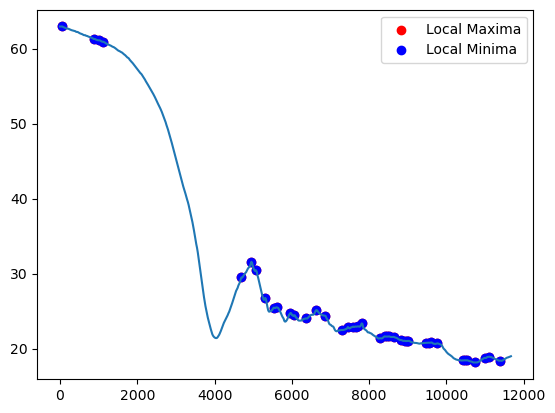

In [42]:
plt.plot(m,y)
plt.scatter(m[local_maxima_indices], y[local_maxima_indices], color='red', label='Local Maxima')
plt.scatter(m[local_minima_indices], y[local_minima_indices], color='blue', label='Local Minima')
plt.legend()
plt.show()

In [62]:
maxima = argrelextrema(y.values, np.greater, order=60)
minima = argrelextrema(y.values, np.less, order =60)

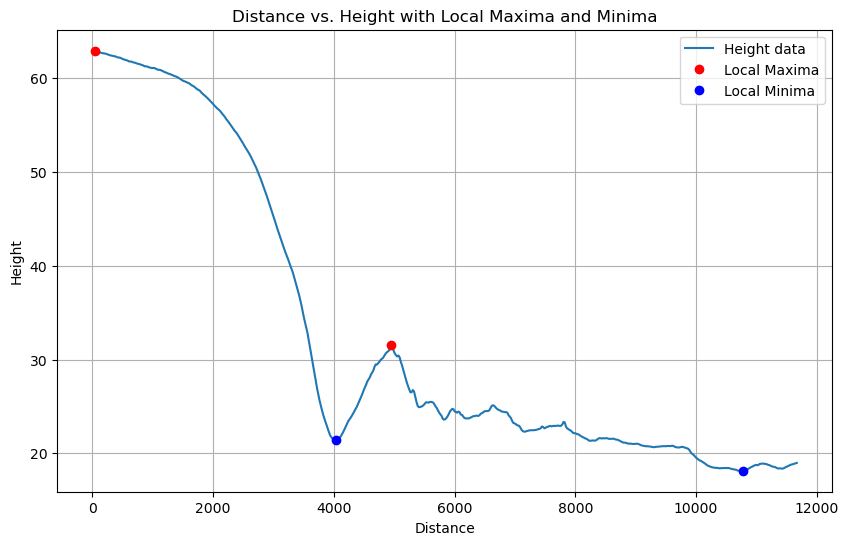

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(m, y, label='Height data')
plt.plot(m[maxima], y[maxima], 'ro', label='Local Maxima')
plt.plot(m[minima], y[minima], 'bo', label='Local Minima')
plt.title('Distance vs. Height with Local Maxima and Minima')
plt.xlabel('Distance')
plt.ylabel('Height')
plt.legend()
plt.grid(True)
plt.show()

Distance between second maxima and first minima: 911.2093120769018 meters
Elevation change between second maxima and first minima: <xarray.DataArray 'h_li' ()>
array(10.174381, dtype=float32) meters
Midpoint between the maxima and minima: <xarray.DataArray 'h_li' ()>
array(5.08719063) meters


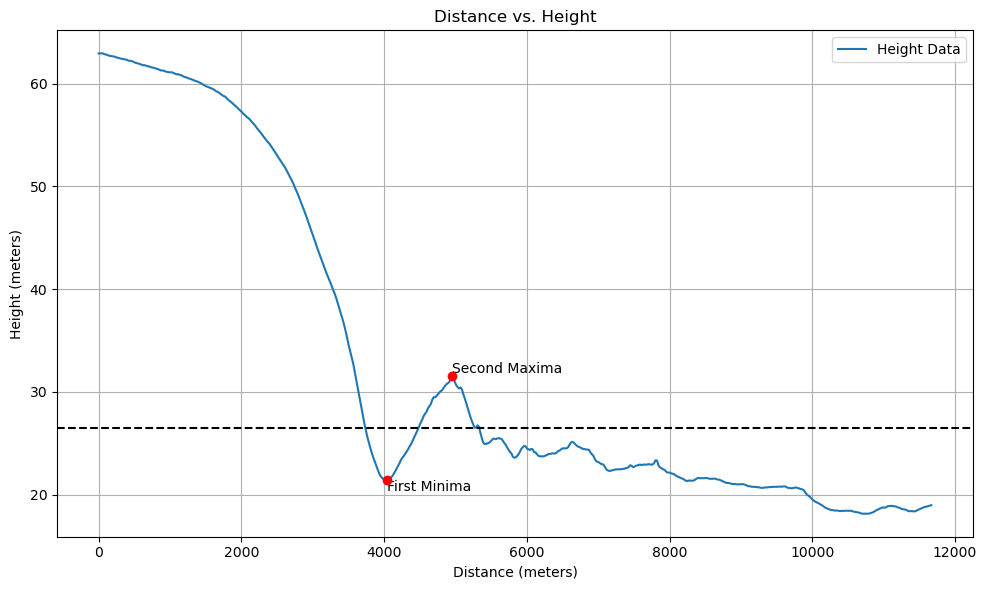

In [99]:
# Find local maxima and minima
local_maxima_indices = argrelextrema(y.values, np.greater, order=59)[0]
local_minima_indices = argrelextrema(y.values, np.less, order=59)[0]

# Extract the second maxima and the first minima
second_maxima_index = local_maxima_indices[1]
first_minima_index = local_minima_indices[0]

second_maxima_position = m[second_maxima_index]
first_minima_position = m[first_minima_index]

second_maxima_value = y[second_maxima_index]
first_minima_value = y[first_minima_index]

# Compute the differences in distance and elevation
distance_difference = abs(second_maxima_position - first_minima_position)
elevation_change = abs(second_maxima_value - first_minima_value)
mid_point = elevation_change/2

print(f"Distance between second maxima and first minima: {distance_difference} meters")
print(f"Elevation change between second maxima and first minima: {elevation_change} meters")
print(f"Midpoint between the maxima and minima: {mid_point} meters")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(m, y, label="Height Data")
plt.scatter([second_maxima_position, first_minima_position], 
            [second_maxima_value, first_minima_value], 
            color='red', zorder=5)
plt.axhline(first_minima_value+mid_point, linestyle='--', color='k')
plt.text(second_maxima_position, second_maxima_value, 'Second Maxima', verticalalignment='bottom')
plt.text(first_minima_position, first_minima_value, 'First Minima', verticalalignment='top')
plt.title("Distance vs. Height")
plt.xlabel("Distance (meters)")
plt.ylabel("Height (meters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate distance between maxima and "start" of concave curve. Draw a line, find intersection, calculate distance.

def find_primary_extrema(distance, height):
    min_distance_from_edge = len(distance) // 10  # Ensuring extrema aren't near the edges.
    
    order = 1
    max_order = len(distance) // 5  # Set an upper limit to avoid indefinite loops
    
    while order < max_order:
        minima_indices = argrelextrema(height, np.less, order=order)[0]
        maxima_indices = argrelextrema(height, np.greater, order=order)[0]

        # Filter out minima and maxima that are too close to the edges
        minima_indices = minima_indices[np.logical_and(minima_indices > min_distance_from_edge, minima_indices < len(distance) - min_distance_from_edge)]
        maxima_indices = maxima_indices[np.logical_and(maxima_indices > min_distance_from_edge, maxima_indices < len(distance) - min_distance_from_edge)]
        
        # Check if we have a single minima and maxima
        if len(minima_indices) == 1 and len(maxima_indices) == 1 and minima_indices[0] < maxima_indices[0]:
            minima_position = distance[minima_indices[0]]
            minima_height = height[minima_indices[0]]
            maxima_position = distance[maxima_indices[0]]
            maxima_height = height[maxima_indices[0]]
            
            distance_between_ = distance[maxima_indices[0]]-distance[minima_indices[0]]
            
            return (minima_position, maxima_position, minima_height, maxima_height, distance_between_, order)
        
        order += 1

    # If we exit the loop without a return, it means we couldn't find suitable extrema
    return None


In [122]:
#minima_position, maxima_position, minima_height, maxima_height, distance_between, order = find_main_features(m, y.values)
minima_position, maxima_position, minima_height, maxima_height, distance_between, order = find_primary_extrema(m,y.values)

mid_point = (maxima_height - minima_height)/2

print("Minima Height:", minima_height)
print("Maxima Height:", maxima_height)
print("Mid point", mid_point)
print("Distance Between:", distance_between)
print("Order Used:", order)

Minima Height: 21.393784
Maxima Height: 31.568165
Mid point 5.087190628051758
Distance Between: 911.2093120769018
Order Used: 57


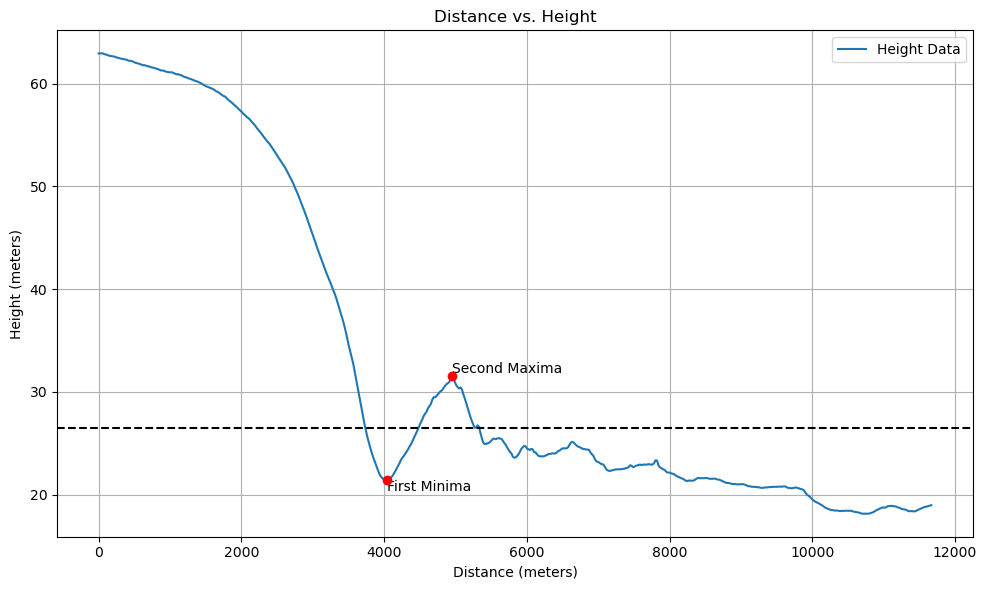

In [123]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(m, y, label="Height Data")
plt.scatter([maxima_position, minima_position], 
            [maxima_height, minima_height], 
            color='red', zorder=5)
plt.axhline(minima_height+mid_point, linestyle='--', color='k')
plt.text(maxima_position, maxima_height, 'Second Maxima', verticalalignment='bottom')
plt.text(minima_position, minima_height, 'First Minima', verticalalignment='top')
plt.title("Distance vs. Height")
plt.xlabel("Distance (meters)")
plt.ylabel("Height (meters)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Look at all the cycles (keep in mind some cycles might have clouds and would need to remove those). Some of them have no data so would need to take that into account in a function) and do this analysis to extract the maxima, minima and whatever and then also plot them to see how stuff changes in time. 
# We have the indices of the location of the minima and maxima so we can use the indices to find the location of the feature in latitude and then plot.

The dominant frequency component is: 8.556271882261962e-05 cycles/unit_distance


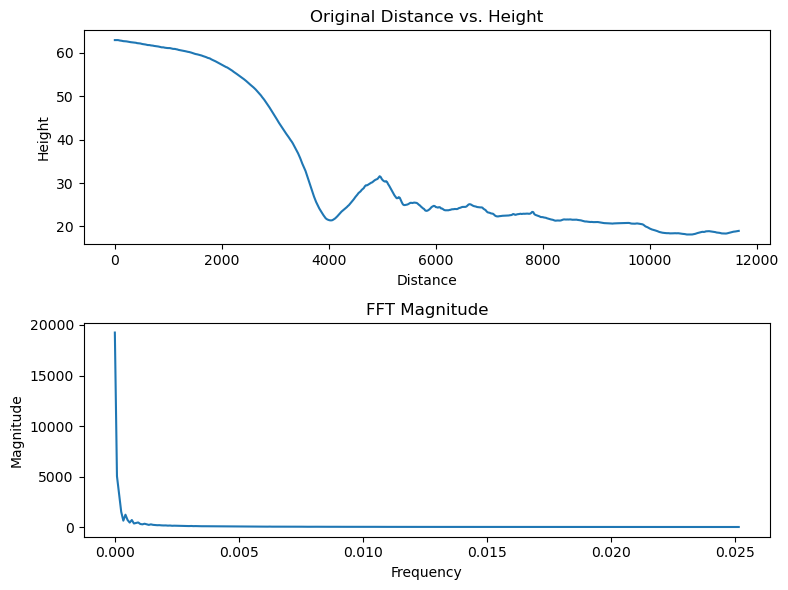

In [74]:
# FFT
height_fft = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(m), d=(m[1]-m[0]))  # Frequencies associated with the FFT components

magnitude = np.abs(height_fft)[1:]

# Find the dominant frequency component
dominant_frequency = frequencies[np.argmax(magnitude) + 1]  # +1 to account for the skipped DC component

print(f"The dominant frequency component is: {dominant_frequency} cycles/unit_distance")

wavelength = 1/dominant_frequency

print(f"The wavelength is: {wavelength} m. This is a very long wavelength indicating that this is a large-scale variation in the landscape.")

# Higher frequency behaviour is secondary given the low frequency of this feature. This is a very large geological structure. Note that these features can be difficult 
# to detect if we don't have enough spatial or temporal data. Might want to do this analysis on more temporal data.

# Plot
plt.figure(figsize=(8, 6))

# Original data
plt.subplot(2, 1, 1)
plt.plot(m, y)
plt.title('Original Distance vs. Height')
plt.xlabel('Distance')
plt.ylabel('Height')

# Magnitude of the FFT (ignoring the negative frequencies)
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(height_fft)[:len(frequencies)//2])
plt.title('FFT Magnitude')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
#plt.xlim((0,0.001))
#plt.ylim((0,5000))

plt.tight_layout()
plt.show()